# Butina Clustering
The Butina algorithm as first described in 1999 ([*J. Chem. Inf. Comput. Sci.* **1999**, *39*, 747-750](https://pubs.acs.org/doi/10.1021/ci9803381)) specifically for clustering molecules. 

## Imports & Settings

In [16]:
### Imports
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Add the utils directory to the path
sys.path.append(os.path.abspath("../utils"))

from butina import Butina

# Data
The chemical structures of BRD4 inhibitors are encoded in bit vectors. For this data set **Morgan fingerprints** `rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect` was used. 






In [3]:
### Load the data
df = pd.read_pickle("data/morgan_2048_df.pkl")
df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
ID,,,,,,,,,,,,,,,,,,,,,
CHEMBL1232461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1233528,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1313432,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1344420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1361699,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL5440963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Method
1) The Tanimoto similarity will be used as distance metric. The only hyperparameter is the **Tanimoto threshold**.
2) All compounds within this threshold are considered **neighbors**. 
3) The compound with the most neighbors is defined as the **centroid** of the first cluster. All its neighbors are cluster members.
4) Compounds assigned to a cluster (both as centroid or cluster member) are ignored for defining the next cluster. Step 3 is repeated until all compounds with neighbors have been assigned to a cluster.
5) Compounds not assigned to a cluster are defined as **singletons**. 


Demonstrative example for Butina clustering

<img src="images/butina.svg" alt="Butina" width="400">

- The Butina algorithm is deterministic.
- Singletons can be within the defined Tanimoto threshold of compounds assigned to a centroid with more neighbors.
- The assumption of this method is that the compound with the most neighbors within a cluster - the centroid - best represents all cluster features. 
- Because the number of clusters is not pre-defined and all cluster members are within the Tanimoto threshold of its centroid clusters tend to be more homogenous compared to other methods. This is because chemical data sets are often distributed very unevenly.  



## Tanimoto Similarity

The Tanimoto similarity between two binary fingerprints **A** and **B** it is defined as:

$$
\text{Tanimoto}(A, B) = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}
$$

Where:
- $ |A \cap B| $ is the number of bits that are 1 in both A and B (i.e., the intersection)
- $ |A| $ is the number of bits that are 1 in A
- $ |B| $ is the number of bits that are 1 in B

<img src="images/tanimoto_venn.svg" alt="Tanimoto Similarity Venn Diagram" width="400">

- Identical molecules have $\text{Tanimoto}(A, A) = 1$
- Very dissimilar molecules have $\text{Tanimoto}(A, B) = 0$
- Tanimoto similarity is closely related to Jaccard distance $ \text{Tanimoto} = 1 - \text{Jaccard} $

## Similarity matrix
A full similarity matrix (containing the similarities between all compounds) is calculated. The computational expensive step for this is the calculation of the intersection matrix ($|A \cap B|$). For the calculation fingerprints as boolean and integers were considered. 

In [4]:
demo_df = pd.DataFrame(
    {
        "ID": ["F1", "F2", "F3", "F4", "F5"],
        "bit_0": [1, 0, 1, 0, 1],
        "bit_1": [1, 0, 1, 1, 0],
        "bit_2": [0, 1, 0, 1, 0],
        "bit_3": [1, 0, 1, 0, 1],
    }
).set_index("ID")
demo_df

,bit_0,bit_1,bit_2,bit_3
ID,,,,
F1,1,1,0,1
F2,0,0,1,0
F3,1,1,0,1
F4,0,1,1,0
F5,1,0,0,1


**Fingerprints as integers**

When using integers the intersection matrix can be calculated as the dot product. 

In [5]:
X_int = demo_df.to_numpy().astype(int)
intersection_matrix = X_int @ X_int.T
pd.DataFrame(intersection_matrix, index=demo_df.index, columns=demo_df.index)

ID,F1,F2,F3,F4,F5
ID,,,,,
F1,3,0,3,1,2
F2,0,1,0,1,0
F3,3,0,3,1,2
F4,1,1,1,2,0
F5,2,0,2,0,2


**Fingerprints as boolean**

When more memory-efficient boolean values are used, the intersection matrix can be calculated using `np.bitwise_and`. However, an additional dimension has to be added to the tensor to enable broadcasting. Therefore, this approach is expected to be less efficient for high dimensionalities (number of compounds > 1000 and number of fingerprints > 1000). 

In [6]:
X_bool = demo_df.to_numpy().astype(bool)
intersection_matrix = np.bitwise_and(X_bool[:, None, :], X_bool[None, :, :]).sum(axis=2)
pd.DataFrame(intersection_matrix, index=demo_df.index, columns=demo_df.index)

ID,F1,F2,F3,F4,F5
ID,,,,,
F1,3,0,3,1,2
F2,0,1,0,1,0
F3,3,0,3,1,2
F4,1,1,1,2,0
F5,2,0,2,0,2


# `Butina` Class
The algorithm is defined in [utils/butina.py](utils/butina.py) as a class containing the methods to perform Butina clustering. 


| Method        | Function Type           | Description                                           |
|---------------|-------------------------|-------------------------------------------------------|
| `__init__()`  | Constructor             | Initializes the class.       |
| `fit()`       | Public                  | Calls `_compute_similarity_matrix()` initially, followed by  `_assign_next_cluster()` in a while loop until all compounds are assigned to a cluster.  |
| `_compute_similarity_matrix()` | Helper | Computes the similarity matrix and assigns it as class attribute. |
| `_assign_next_cluster()`       | Helper | Subsets `similarity_df` to compounds not assigned to a cluster and defines the next cluster (the compound with most neighbors is the centroid) |

Class attributes are

| Attribute     | Type         | Description                              |
|---------------|--------------|------------------------------------------|
| `threshold`     | float        | Similarity thereshold for clustering     |
| `df`            | pd.DataFrame | Input data: binary fingerprints with unique index           |
| `similarity_df` | pd.DataFrame | Similarity matrix (symmetrical)    |
| `cluster_df`    | pd.DataFrame | Cluster assignments. Same length and index as df. |




# Demo

In [36]:
model = Butina(threshold=0.75)
pred_df = model.fit(df.sample(1000))
pred_df

Similarity matrix computation
Clustering


100%|█████████▉| 99.99999999999841/100 [00:03<00:00, 25.81it/s] 


,Cluster,Centroid,Singleton
ID,,,
CHEMBL4213012,15,False,False
CHEMBL4063112,112,True,True
CHEMBL4776770,36,True,False
CHEMBL4645406,113,True,True
CHEMBL4078019,114,True,True
...,...,...,...
CHEMBL5092030,820,True,True
CHEMBL4755667,28,False,False
CHEMBL5198491,821,True,True


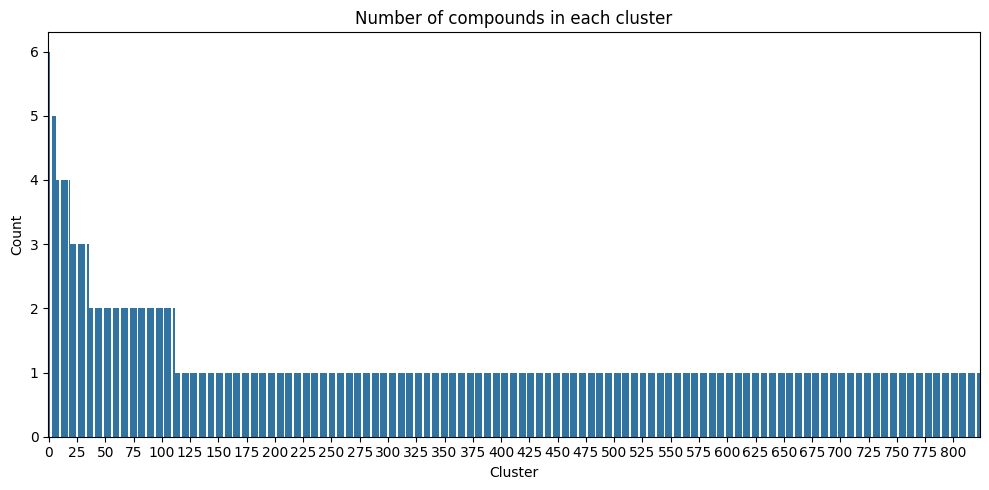

In [37]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="Cluster", data=pred_df)

ticks = ax.get_xticks()
ax.set_xticks(ticks[::25])  # Show every 10th cluster
ax.set_xticklabels([int(t) for t in ticks[::25]], rotation=0)

plt.title("Number of compounds in each cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# Sandbox

In [42]:
pred_df["Cluster"].value_counts().value_counts()

count
1    712
2     76
3     17
4     12
5      5
6      2
Name: count, dtype: int64

In [29]:
pred_df["Cluster"].value_counts()

Cluster
0      25
2      22
1      22
3      17
4      16
       ..
234     1
235     1
236     1
237     1
364     1
Name: count, Length: 365, dtype: int64

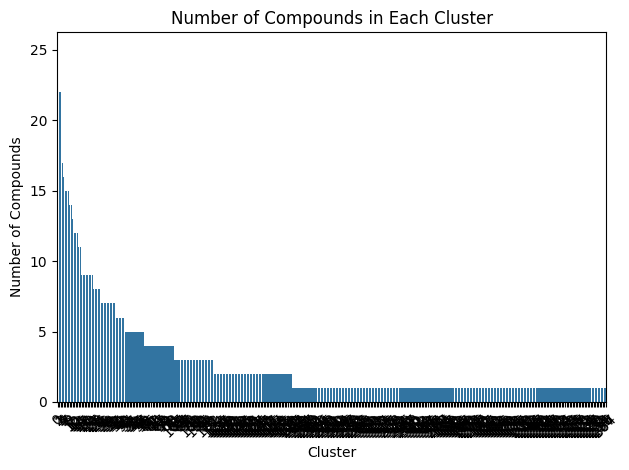

In [18]:
sns.countplot(
    x="Cluster",
    data=pred_df,
    order=pred_df["Cluster"].value_counts().index,
)
plt.title("Number of Compounds in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Compounds")
plt.xticks(rotation=45)  # Rotate labels for clarity
plt.tight_layout()
plt.show()


In [9]:
model.similarity_df.max().max()

0.9868421052631579